# Deconvolution of the thickness effect

This is the third part of this long journey in the thickness of the silicon sensor of the Pilatus detector:
After characterizing the precise position of the Pilatus-1M on the goniometer of ID28 we noticed there are some discrepancies in the ring position and peak width as function of the position on the detector. 
In a second time the thickness of the detector was modeled and allowed us to define a sparse-matrix which represent the bluring of the signal with a point-spread function which actually depends on the position of the detector.
This convolution can be revereted using techniques developped for inverse problems. 

We will now correct the images of the first notebook called "goniometer" with the sparse matrix calculated in the second one (called "raytracing") and check if the pick-width is less chaotic.

In [1]:
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#Specific for ESRF
import os
os.environ["http_proxy"] = "http://proxy.esrf.fr:3128"

In [2]:
import fabio, pyFAI, os
from os.path import basename
from pyFAI.gui import jupyter
from pyFAI.calibrant import get_calibrant
from silx.resources import ExternalResources

downloader = ExternalResources("thick", "http://www.silx.org/pub/pyFAI/testimages")
all_files = downloader.getdir("gonio_ID28.tar.bz2")
for afile in all_files:
    print(basename(afile))

gonio_ID28
det130_g45_0001p.npt
det130_g0_0001p.cbf
det130_g17_0001p.npt
det130_g0_0001p.npt
det130_g45_0001p.cbf
det130_g17_0001p.cbf


In [3]:
from scipy.sparse import save_npz, load_npz, csr_matrix, csc_matrix, linalg
#Saved in notebook called "raytracing"
csr = load_npz("csr.npz")

<IPython.core.display.Javascript object>


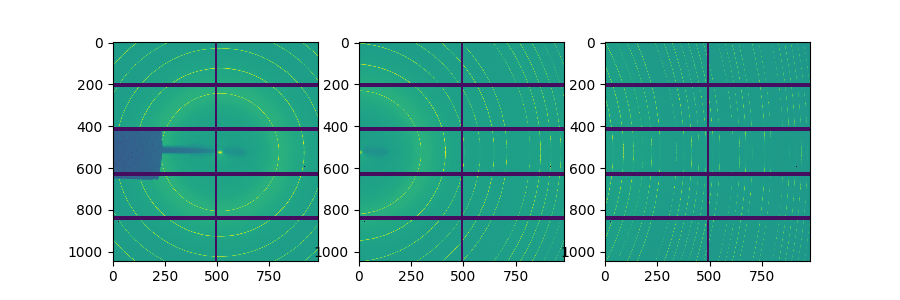

In [6]:
mask = numpy.load("mask.npy")
images = [fabio.open(i).data for i in sorted(all_files) if i.endswith("cbf")]

fig, ax = subplots(1, 3, figsize=(9,3))
for i, img in enumerate(images):
    ax[i].imshow(numpy.arcsinh(img))

<IPython.core.display.Javascript object>


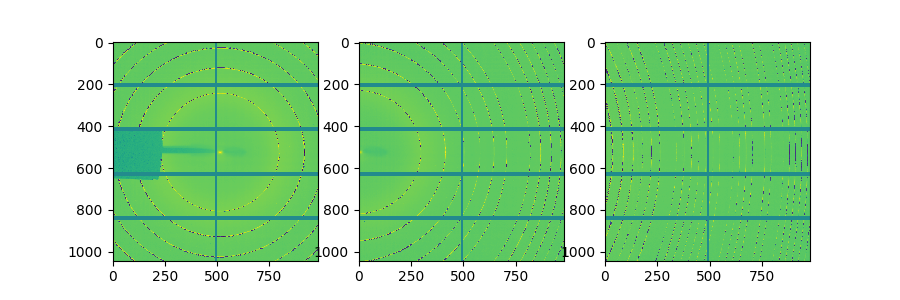

(1, 23, 66.70987399605569, 10.158270983765981, 1.862080889148464, 4.1457039198038652, 44893427.485308647)
(1, 23, 58.916625196254635, 9.5709507555976376, 1.8666609017532882, 4.0146845391231922, 38902815.355951048)
(1, 24, 28.59430045453111, 4.7422569251327822, 1.8989417893747016, 3.9796981410935794, 16639924.368782267)


In [11]:
fig, ax = subplots(1, 3, figsize=(9,3))

msk = numpy.where(mask)
for i,img in enumerate(images):
    fl = img.astype("float32")
    fl[msk] = 0.0 # set masked values to 0
    bl = fl.ravel()
    res = linalg.lsmr(csr.T, bl)
    print(res[1:])
    cor = res[0].reshape(img.shape)
    ax[i].imshow(numpy.arcsinh(cor))

It turns out the deconvolution is not that straight forwards and creates some negative wobbles near the rings. 
This phenomenon is well known in inverse methods which provide a damping factor to limit the effect. This damping factor needs to be adjusted manually to avoid this.

In [12]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

<IPython.core.display.Javascript object>


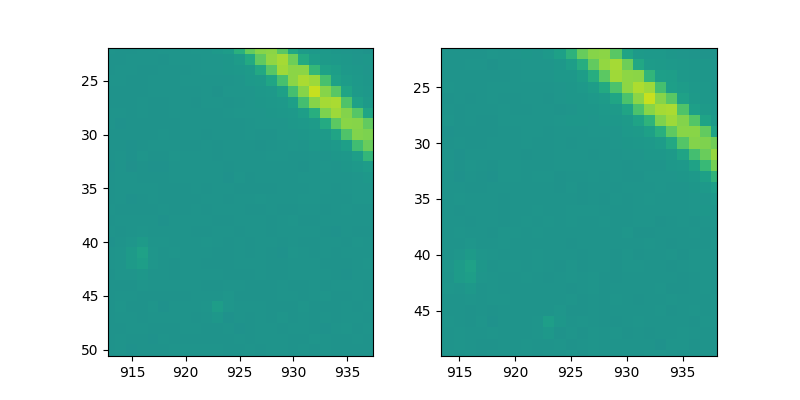

interactive(children=(FloatSlider(value=2.5, description='damp', max=5.0), Output()), _dom_classes=('widget-interact',))

In [16]:
img = images[0]
fl = img.astype("float32")
fl[msk] = 0.0 # set masked values to 0
blured = fl.ravel()
fig, ax = subplots(1, 2, figsize=(8,4))
im0 = ax[0].imshow(numpy.arcsinh(fl))
im1 = ax[1].imshow(numpy.arcsinh(fl))

def deconvol(damp):
    res = linalg.lsmr(csr.T, blured, damp=damp, x0=blured)
    restored = res[0].reshape(mask.shape)
    im1.set_data(numpy.arcsinh(restored))
    print("Number of negative pixels: %i"%(restored<0).sum())


interactive_plot = widgets.interactive(deconvol, damp=(0, 5.0))
display(interactive_plot)

In [20]:
#selection of the damping factor which provides no negative signal:
tot_neg = 1
damp = 0
while tot_neg:
    damp += 0.1
    tot_neg = 0
    deconvoluted = []
    for i, img in enumerate(images):
        fl = img.astype("float32")
        fl[msk] = 0.0 # set masked values to 0
        bl = fl.ravel()
        res = linalg.lsmr(csr.T, bl, damp=damp, x0=bl)
        neg=(res[0]<0).sum()
        print(i, damp, neg, res[1:])
        tot_neg += neg
        deconvoluted.append(res[0].reshape(img.shape))
print(damp)

0 0.1 12467 (2, 20, 2719147.5671234373, 3.0520162896634555, 1.734637266382471, 3.5045621708446353, 42710613.919440895)
1 0.1 12133 (2, 20, 2226923.6582547836, 2.9711087018673652, 1.739477470359506, 3.4718340266994328, 37334898.970831536)
2 0.1 17428 (2, 21, 1030416.3472196753, 1.2118273918641858, 1.7730267422935109, 3.5253028664262192, 15546410.891239503)
0 0.2 10792 (2, 14, 4890971.88235519, 4.0930015339868007, 1.4590652627238616, 2.7261991275012711, 38376808.606932491)
1 0.2 10380 (2, 14, 4053981.7824809635, 3.6523074807546885, 1.4639752470904785, 2.7339801228367526, 34103578.905226201)
2 0.2 14584 (2, 14, 1809606.9346236284, 2.2734080529228056, 1.4566153988811077, 2.7222106754746656, 13689172.919802172)
0 0.30000000000000004 8356 (2, 11, 6457242.240949305, 2.9659819602604389, 1.298927291870386, 2.2619009974429969, 34164171.241372257)
1 0.30000000000000004 8513 (2, 11, 5415476.373028647, 2.5534866381307619, 1.3048181982305638, 2.244477606746718, 30763121.487005971)
2 0.30000000000000

1 2.3000000000000007 6 (2, 3, 9192265.25460275, 4.3224663180298339, 0.7201770216498942, 1.0061520987260917, 17455038.836616185)
2 2.3000000000000007 0 (2, 3, 3745380.027086064, 2.1708603574224621, 0.6996681857456813, 1.0053678937810866, 6678603.3342214571)
0 2.400000000000001 11 (2, 3, 10610379.278916264, 3.9821875867724805, 0.7101657577230704, 1.0048327657155758, 19063811.540534656)
1 2.400000000000001 5 (2, 3, 9205545.606193116, 3.3743385236583747, 0.7201770216498942, 1.0056526851905581, 17397700.560478397)
2 2.400000000000001 0 (2, 3, 3750078.8244628133, 1.69395812861791, 0.6996681857456813, 1.0049276658984336, 6657424.3884031754)
0 2.500000000000001 11 (2, 3, 10622927.55310798, 3.1379001396720585, 0.7101657577230704, 1.0044540525286187, 19010125.583755448)
1 2.500000000000001 3 (2, 3, 9217318.137405135, 2.6594187054316145, 0.7201770216498942, 1.0052115869153366, 17346814.205681115)
2 2.500000000000001 0 (2, 3, 3754243.235615748, 1.3345528905898829, 0.6996681857456813, 1.00453947833

<IPython.core.display.Javascript object>


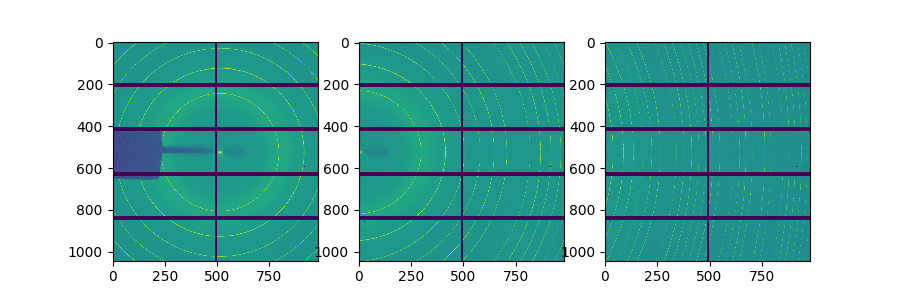

In [21]:
fig, ax = subplots(1, 3, figsize=(9,3))
for i,img in enumerate(deconvoluted):
    ax[i].imshow(numpy.arcsinh(img))